<a href="https://colab.research.google.com/github/johanhoffman/DD2363-VT19/blob/bozzato/Lab-5/bozzato_lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lab 5: Ordinary differential equations**
**Bozzato Federico**

# **Abstract**

Short summary of the lab report. State the objectives, methods used, main results and conlusions. 

#**About the code**

A short statement on who is the author of the file, and if the code is distributed under a certain license. 

In [1]:
"""This program is a template for lab reports in the course"""
"""DD2363 Methods in Scientific Computing, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2019 Johan Hoffman (jhoffman@kth.se)

# This file is part of the course DD2363 Methods in Scientific Computing
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This template is maintained by Johan Hoffman
# Please report problems to jhoffman@kth.se

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

To have access to the neccessary modules you have to run this cell. If you need additional modules, this is where you add them. 

In [0]:
# Load neccessary modules.
from google.colab import files

import numpy as np

from matplotlib import pyplot as plt

## Useful functions from previous labs
Functions taken from [here](https://github.com/johanhoffman/DD2363-VT19/blob/bozzato/Lab-3/bozzato_lab3.ipynb.)

In [0]:
def derivative(fun, point, h, opt):
  '''
  Calculates the first order derivative of the function @fun at the point @point.
  Parameters:
  - fun: function for which the 1st order derivative is wanted
  - point: point where to calculate the derivative
  Output:
  - derivative: central 1st order derivative
  '''
  ode= opt[0]
  step= opt[1]
  theta= opt[2]
  u0= opt[3]
  t0= opt[4]
  u1= opt[5]
  t1= opt[6]
  f1= fun(ode,step,theta,u0,t0,u1+h,t1)
  f2= fun(ode,step,theta,u0,t0,u1-h,t1)
  
  return (f1 - f2) / (2*h)               # central derivative f'= (f(x+1) - f(x-1))/2



def newtonScalarNLeq(fun, opt, h= 0.1, tol= 1e-5):
  '''
  Solve the scalar nonlinear equation f(x) = 0, where f(x) is the function @fun.
  The method used is Newton's method.
  Parameters:
  - fun: function 
  - point: starting guess for the iteration
  - der (default = None): derivative of the function @fun, calculated manually. 
  - h (default = 0.1): dx used in computing the derivative
  - tol (default= 1e-5): tolerance to stop the iterations
  Output:
  - x: point x such that f(x)=0
  - residuals: vector containing all the residuals for each iteration
  - iter: number of iterations for reaching the convergence
  '''
  
  ode= opt[0]
  step= opt[1]
  theta= opt[2]
  u0= opt[3]
  t0= opt[4]
  u1= opt[5]
  t1= opt[6]
  
  
  if not callable(fun):
    print('Error: impossible to continue! Parameter @fun is not callable()')
    return None, None
    
  # loop until convergence is not reached
  residuals= []
  x= u1.item()
  res= np.absolute(fun(ode,step,theta,u0,t0,x,t1))
  residuals.append(res)
  k= 1
  while res >= tol and k < 1000:
    alpha= derivative(fun, x, h, opt)
    
    x= x - fun(ode,step,theta,u0,t0,x,t1)/alpha
    res= np.absolute(fun(ode,step,theta,u0,t0,x,t1))
    residuals.append(res)
    k+= 1
    
  return x, np.array(residuals), k




def jacobian(fun,point,h):
  '''
  Calculates the Jacobian matrix for the vector function @fun at the point @point.
  Parameters:
  - fun: function for which the Jacobian matrix is wanted
  - point: point where to calculate the Jacobian
  - h (default= 1): incrementation for the derivative
  Output:
  - jacobian: jacobian matrix of the function @fun
  '''
  if not isinstance(point, np.ndarray):
    point = np.array(point)
    
  n= len(point)
  
  jacobian= np.zeros((n,n))
  for i in range(0,n):
    pp1= [p for p in point]
    pp2= [p for p in point]
    
    pp1[i]= pp1[i] + h
    pp2[i]= pp2[i] - h
    
    jacobian[:,i]= ((fun(pp1) - fun(pp2)) / (2*h)).T
  
  return jacobian
  
  
  
  
def newtonNLsystems(fun, initialPoint, h=0.1, tol= 1e-5):
  '''
  Solve the vector nonlinear system of equations f(x) = 0, where f(x) is the
  vector function @fun.
  The method used is Newton's method.
  Parameters:
  - fun: vector function 
  - point: starting guess for the iteration
  - J (default= None): the Jacobian matrix of the vector function. It improves
    algorithm performances.
    - h (default = 0.1): dx used in computing the derivative
  - tol (default= 1e-5): tolerance to stop the iterations
  Output:
  - x: point x such that f(x)=0
  - residuals: vector containing all the residuals for each iteration
  - iter: number of iterations for reaching the convergence
  '''
  if not callable(fun):
    print('Error: impossible to continue! Parameter @fun is not callable()')
    return None, None
  
  if not isinstance(initialPoint, np.ndarray):
    intialPoint = np.array(initialPoint)
    
  x= initialPoint
  k = 1
  residuals= []
  res= linalg.norm(fun(x))
  residuals.append(res)
  while res >= tol and k < 1000:                                      # res= |f(x)|
    jac= jacobian(fun,x,h)
    
    b= - fun(x)
    dx, _, _, _ = linalg.lstsq(jac, b, rcond=None)       # built-in function
    x = x + dx                    
    res= linalg.norm(fun(x))
    residuals.append(res)
    k+= 1
    
  return x, np.array(residuals), k

# **Introduction**

Give a short description of the problem investigated in the report, and provide some background information so that the reader can understand the context. 

Briefly describe what method you have chosen to solve the problem, and justify why you selected that method. 

Here you can express mathematics through Latex syntax, and use hyperlinks for references.

[Hyperlink to DD2363 course website.](https://kth.instructure.com/courses/7500)

$
{\displaystyle \frac{\partial u}{\partial t}} + u\cdot \nabla u +\nabla p = f, \quad \nabla \cdot u=0$



#Mandatory assignment

##Methods

###1. Time stepping for scalar initial value problem $du/dt= f(u,t)$

Input: final time T, function f(u,t), initial value u(0)

Output: approximation U(t_n) for the time interval $[0,T$] 

Test: verify accuracy and stability of chosen method 

In [0]:
def odeSolver(T, odeFun, theta, u0, N):
  
  def stepFunction(ode,step,theta,u0,t0,u1,t1):
    
    # u1 is my variable x to be found
    tmp= u0 + step*((1-theta) * ode(u1,t1) + theta * odeFun(u0,t0))
    
    if theta != 1:
      tmp -= u1
    
    return tmp
  
  step= T/N
  intervals= np.arange(0, T+step, step)
  
  U= np.zeros((len(intervals),1))
  U[0]= u0
  
  for i in range(1,len(intervals)): 
    opt= [0 for _ in range(0,7)]
    opt[0]= odeFun
    opt[1]= step
    opt[2]= theta
    opt[3]= U[i-1][0]
    opt[4]= intervals[i-1]
    opt[5]= U[i-1][0]
    opt[6]= intervals[i]
    if theta != 1:
      U[i]= newtonScalarNLeq(stepFunction, opt, h= 0.1, tol= 1e-5)[0]
    else:
      U[i]= U[i-1] + step * odeFun(U[i-1],intervals[i-1])
  
  #TODO: check of stability 
  
  return intervals, U

###2. Time stepping for system of initial value problem $du/dt = f(u,t)$

In [0]:
def systemOdeSolver(T, odeSystem, theta, u0, N):
  if not isinstance(u0,np.ndarray):
    u0= np.array(u0)
  
  
  step= T/N
  x= np.arange(0, T+step, step)
  
  U= np.zeros((u0.shape[0],x.shape[0]))
  U[:,0]= u0
  
  for i in range(1,len(x)):
    U[:,i]= U[:,i-1] + step * odeSystem(U[:,i-1],x[i-1]).flatten()
    
  return x, U
 

##Results

###1. Time stepping for scalar initial value problem $du/dt = f(u,t)$

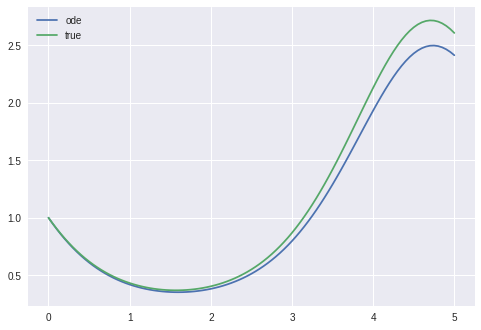

####################################################
####################################################
####################################################


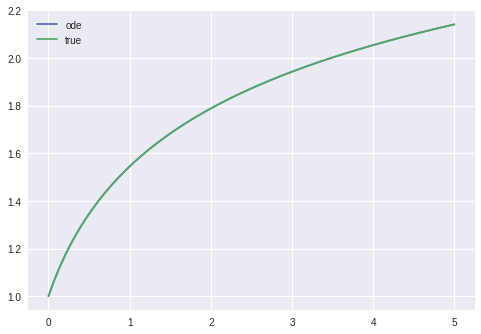

In [6]:
def fun(t):
  return np.e**(-np.sin(t))

def odeFun(u,t):
  return -u*np.cos(t)
    

theta= 1
u0= 1
T= 5

x, y= odeSolver(T,odeFun,theta,u0,100)


plt.figure()
plt.plot(x,y)

y_true= [fun(t) for t in x]
plt.plot(x, y_true)
plt.legend(('ode','true'))
plt.show()

print('####################################################')
print('####################################################')
print('####################################################')

def odeFun(u,t):
  return 1/(u*(t+1))

def fun(t):
  return np.sqrt(2*np.log(t+1)+1)

theta= 0.5
u0= 1
T= 5

x, y= odeSolver(T,odeFun,theta,u0,100)


plt.figure()
plt.plot(x,y)

y_true= [fun(t) for t in x]
plt.plot(x, y_true)
plt.legend(('ode','true'))
plt.show()


###2. Time stepping for system of initial value problems $du/dt = f(u,t)

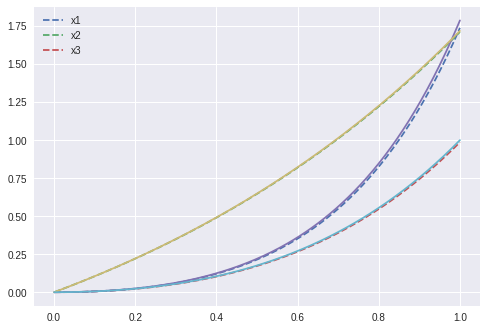

In [7]:
def systemOdeFun(varVect,t):
  x1= varVect[0]
  x2= varVect[1]
  x3= varVect[2]
  fun1= 3*x1 + t
  fun2= x2 + 1
  fun3= x2 + x3
  
  vect= np.array( [[fun1],
                   [fun2],
                   [fun3]] )
  
  return vect

def systemFun(t):
  x1= (1/9)*np.e**(3*t) - (1/3)*t - (1/9)
  x2= np.e**t - 1
  x3= (t-1)*np.e**t + 1
  
  return x1, x2, x3

U0= [0, 0, 0]
x,U= systemOdeSolver(1, systemOdeFun, None, U0, 200)

U1, U2, U3= systemFun(x)


plt.figure()
plt.plot(x,U[0,:], '--')
plt.plot(x,U[1,:], '--')
plt.plot(x,U[2,:], '--')
plt.plot(x,U1)
plt.plot(x,U2)
plt.plot(x,U3)

plt.legend(['x1', 'x2', 'x3'])
plt.show()

##Discussion

Summarize your results and your conclusions. Were the results expected or surprising. Do your results have implications outside the particular problem investigated in this report? 

##References

In this appendix some examples are given to express and visualizing mathematical concepts such as vectors, matrices, meshes and functions. 

This is not part of the template report for the course.

#Extra assignment

##Introduction

##Method

##Results

##Discussion